In [1]:
from spatialSSL.Dataloader import FullImageDatasetConstructor
from spatialSSL.Utils import split_dataset
from spatialSSL.Training import train

from spatialSSL.Training import train_epoch
from spatialSSL.Testing import test
from spatialSSL.Dataset import InMemoryGraphDataset
import numpy as np

/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/geopandas/_compat.py:124: UserWarning: The Shapely GEOS version (3.11.1-CAPI-1.17.1) is incompatible with the GEOS version PyGEOS was compiled with (3.10.4-CAPI-1.16.2). Conversions between both will be slow.
  warnings.warn(
/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/spatialdata/__init__.py:9: UserWarning: Geopandas was set to use PyGEOS, changing to shapely 2.0 with:

	geopandas.options.use_pygeos = True

If you intended to use PyGEOS, set the option to False.
  _check_geopandas_using_shapely()
/home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/torch_geometric/typing.py:31: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/cheng-wei_liao/miniconda3/envs/master_prak/lib/python3.11/site-packages/torch_scatter/_version_cpu.so: undefined symbol: _ZN5torch3jit17parseSchemaOrNameERKNSt7__cxx1112basic

In [2]:
'''
import os
import scanpy as sc

adata = sc.read("./data/atlas_brain_638850_CCF.h5ad")
# subset the adata
selected_img = np.unique(adata.obs["section"])[0:20]
sub_adata = adata[adata.obs["section"].isin(selected_img)].copy()

# specify the output directory and file
output_dir = './data'
os.makedirs(output_dir, exist_ok=True)
output_file = os.path.join(output_dir, 'sub_20img_adata.h5ad')

# write the sub_adata into a .h5ad file
sub_adata.write(output_file)
'''

'\nimport os\nimport scanpy as sc\n\nadata = sc.read("./data/atlas_brain_638850_CCF.h5ad")\n# subset the adata\nselected_img = np.unique(adata.obs["section"])[0:20]\nsub_adata = adata[adata.obs["section"].isin(selected_img)].copy()\n\n# specify the output directory and file\noutput_dir = \'./data\'\nos.makedirs(output_dir, exist_ok=True)\noutput_file = os.path.join(output_dir, \'sub_20img_adata.h5ad\')\n\n# write the sub_adata into a .h5ad file\nsub_adata.write(output_file)\n'

In [2]:
# encode book
category_encoding = {
    'Astro-Epen': 0,
    'CB GABA': 1,
    'CB Glut': 2,
    'CGE GABA': 3,
    'CNU GABA': 4,
    'CNU-HYa GABA': 5,
    'CNU-HYa Glut': 6,
    'HY GABA': 7,
    'HY Glut': 8,
    'HY Gnrh1 Glut': 9,
    'HY MM Glut': 10,
    'IT-ET Glut': 11,
    'Immune': 12,
    'LQ': 13,
    'LSX GABA': 14,
    'MB Dopa': 15,
    'MB GABA': 16,
    'MB Glut': 17,
    'MB-HB Sero': 18,
    'MGE GABA': 19,
    'MH-LH Glut': 20,
    'MOB-CR Glut': 21,
    'MOB-DG-IMN': 22,
    'MY GABA': 23,
    'MY Glut': 24,
    'NP-CT-L6b Glut': 25,
    'OEG': 26,
    'Oligo': 27,
    'P GABA': 28,
    'P Glut': 29,
    'Pineal Glut': 30,
    'TH Glut': 31,
    'Vascular': 32
}
import torch
def convert_to_float32(data_list):
    for data in data_list:
        # Convert attributes to float32
        data.x = data.x.to(dtype=torch.float32)
    return data_list

In [3]:
# Create an instance of Full_image_dataloader

 
#file_path = "./data/img_119670929.h5ad"
file_path = "./data/subset_6img_atlas_brain.h5ad"
#file_path = "./data/atlas_brain_638850_CCF.h5ad"
#file_path = "./data/sub_20img_adata.h5ad"

data_constracter = FullImageDatasetConstructor(file_path=file_path,
                                        image_col="section",
                                        label_col="class_label",
                                        include_label=False,
                                        radius=30,
                                        node_level = 1,
                                       random_mask_percentage = 0.1,
                                        encode_book = category_encoding
                                       #    niche_to_mask = 100
                                       #celltype_to_mask = "LQ"
                                               )


In [5]:
# Load the data
data_constracter.load_data()

In [6]:
data_constracter.random_mask_percentage

0.1

In [15]:
# Construct the graph
graph_list = data_constracter.construct_graph()
graph_list = convert_to_float32(graph_list)

Constructing Graphs:   0%|          | 0/6 [00:00<?, ?it/s]

In [16]:
from sklearn.model_selection import train_test_split

# Split the graph_list into 80% for pre-training and 20% for pre-training validation
pre_train_list, pre_val_list = train_test_split(graph_list, test_size=0.20, random_state=42)


In [18]:
print(len(pre_train_list))
print(len(pre_val_list))

4
2


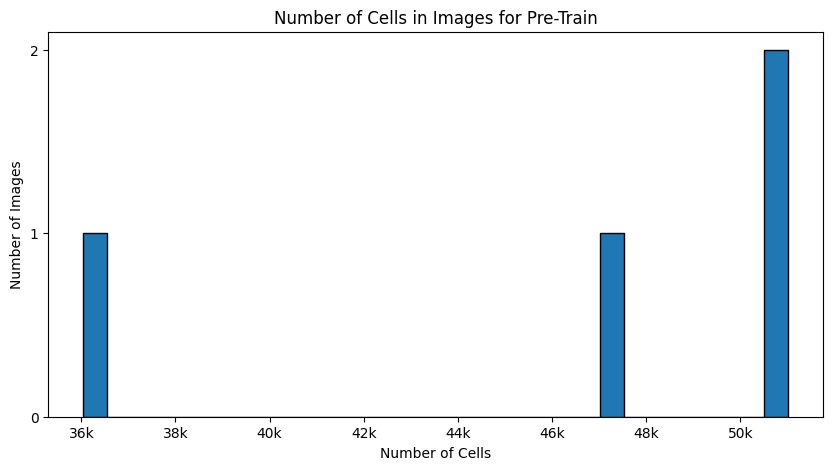

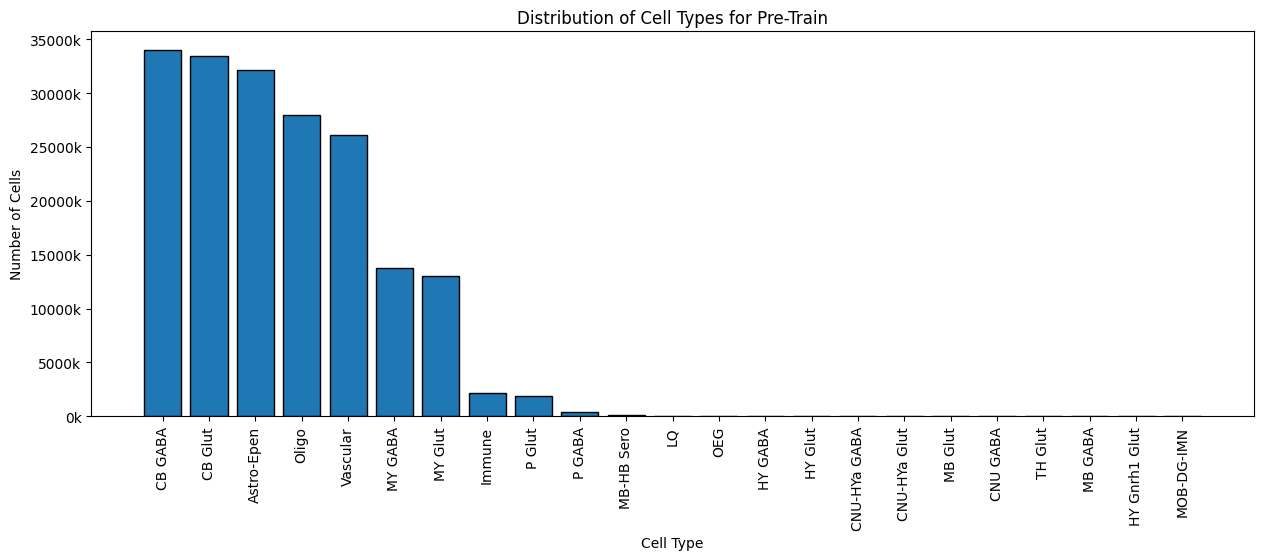

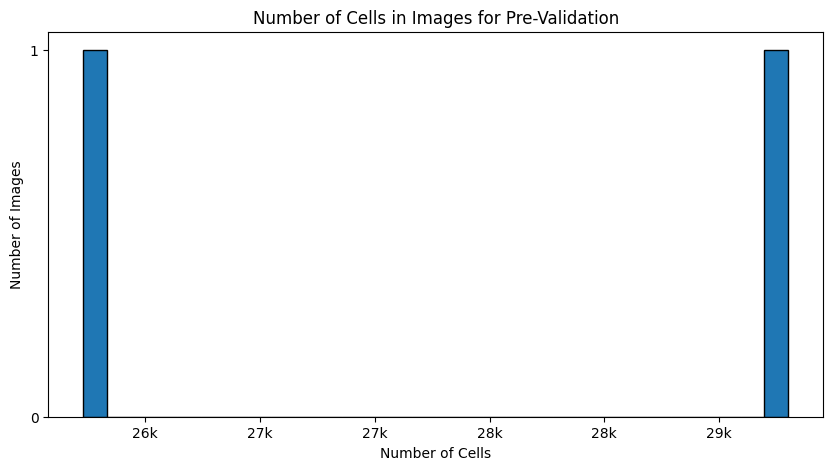

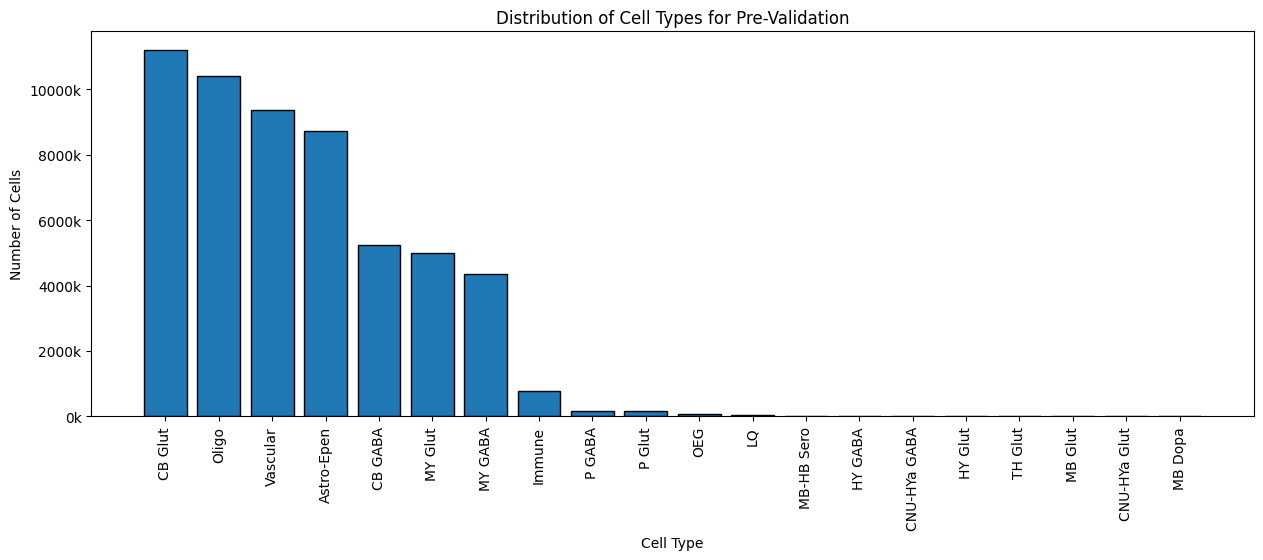

In [27]:
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter
from matplotlib.ticker import FuncFormatter

def thousands(x, pos):
    return f'{int(x)}k'

formatter = FuncFormatter(thousands)

def plot_histogram(graph_list, title, cell_num_path, cell_type_path):
    # Extracting number of cells in x
    num_cells = [data.x.size(0) / 1000 for data in graph_list] # Divide by 1000 to represent in k

    # Plotting histogram for number of cells in x
    plt.figure(figsize=(10, 5))
    plt.hist(num_cells, bins=30, edgecolor='black')
    plt.title(f'Number of Cells in Images for {title}')
    plt.xlabel('Number of Cells')
    plt.ylabel('Number of Images')
    plt.yticks(np.arange(0, max(plt.yticks()[0]), 1)) # Set y-ticks to integer values
    plt.gca().xaxis.set_major_formatter(formatter) # Apply the formatter
    plt.savefig(cell_num_path) # Save the plot
    plt.show()

    # Extracting cell types
    cell_types = [data.cell_type.tolist() for data in graph_list]
    flat_cell_types = [item for sublist in cell_types for item in sublist]

    # Get the encode_book from the first data object in the graph_list
    encode_book = graph_list[0].encode_book

    # Count the frequency of each cell type
    cell_type_counts = Counter(flat_cell_types)

    # Sort cell types by frequency
    sorted_cell_types = sorted(cell_type_counts.items(), key=lambda x: x[1]/1000, reverse=True) # Divide by 1000 to represent in k
    sorted_labels = [list(encode_book.keys())[cell_type[0]] for cell_type in sorted_cell_types] # Convert keys to list
    sorted_values = [cell_type[1] for cell_type in sorted_cell_types]

    # Plotting histogram for distribution of cell types
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(sorted_values)), sorted_values, edgecolor='black')
    plt.title(f'Distribution of Cell Types for {title}')
    plt.xlabel('Cell Type')
    plt.ylabel('Number of Cells')
    plt.gca().yaxis.set_major_formatter(formatter) # Apply the formatter
    plt.xticks(ticks=range(len(sorted_labels)), labels=sorted_labels, rotation=90)
    plt.savefig(cell_type_path) # Save the plot
    plt.show()

# Plot histograms for pre_train_list and pre_val_list
plot_histogram(pre_train_list, 'Pre-Train', './processed_data/plots/pre_train_cell_num_img6_r30_n1_random_01.jpg', './processed_data/plots/pre_train_cell_type_img6_r30_n1_random_01.jpg')
plot_histogram(pre_val_list, 'Pre-Validation', './processed_data/plots/pre_val_cell_num_img6_r30_n1_random_01.jpg', './processed_data/plots/pre_val_cell_type_img6_r30_n1_random_01.jpg')


In [42]:
import zipfile
import torch
def save_to_zip(loader, filename):
    with open(filename, 'wb') as f:
        pickle.dump(loader, f)

# Save train_loader and val_loader to pickle files
torch.save(pre_train_list, './processed_data/pre_train_list.pt')
torch.save(pre_val_list, './processed_data/pre_val_list.pt')

# Create a ZIP file and add the pickle files to it
with zipfile.ZipFile('./processed_data/pre_training_data_img6_r30_n1_random_01.zip', 'w') as zipf:
    zipf.write('./processed_data/pre_train_list.pt', arcname='pre_train_list.pt')
    zipf.write('./processed_data/pre_val_list.pt', arcname='pre_val_list.pt')

print("ZIP file created successfully!")


ZIP file created successfully!


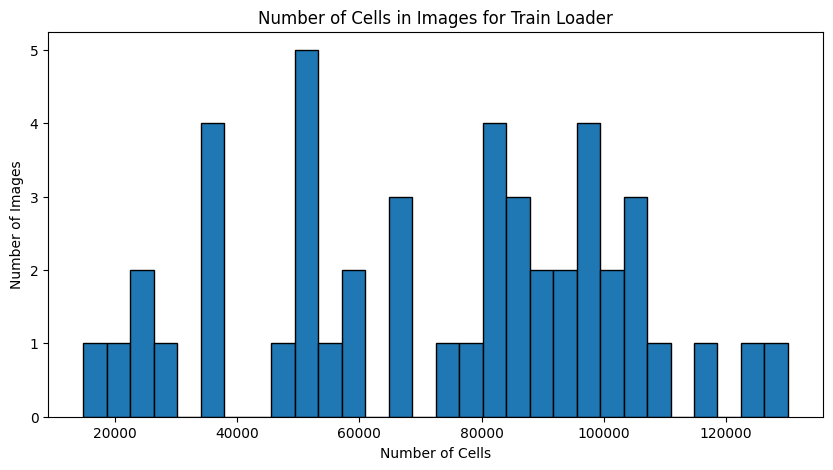

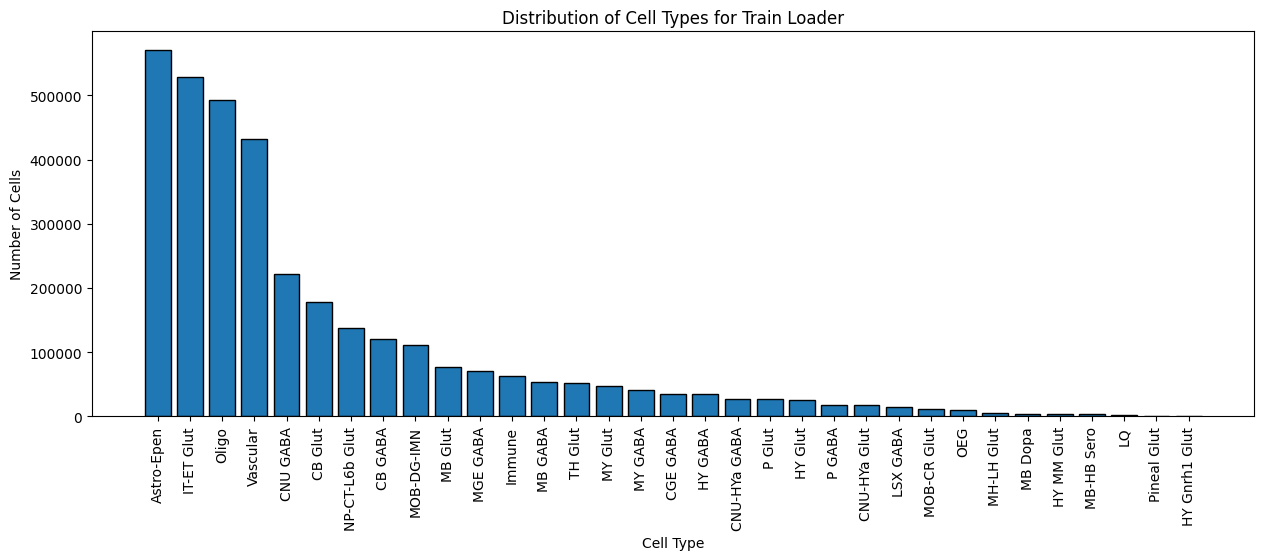

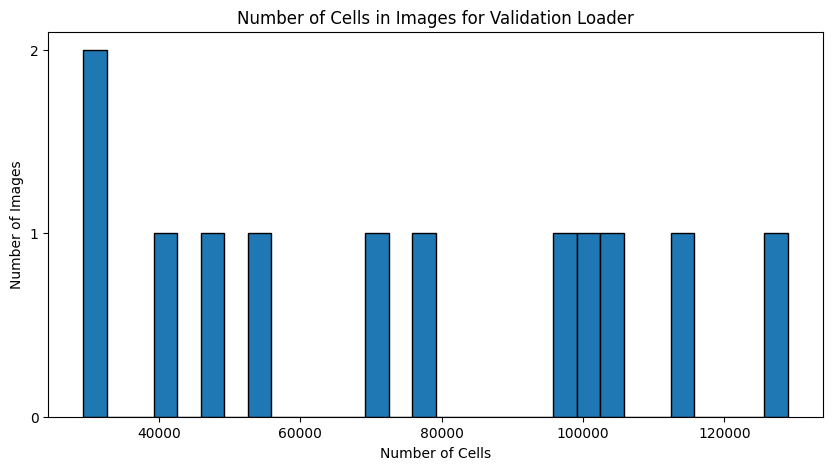

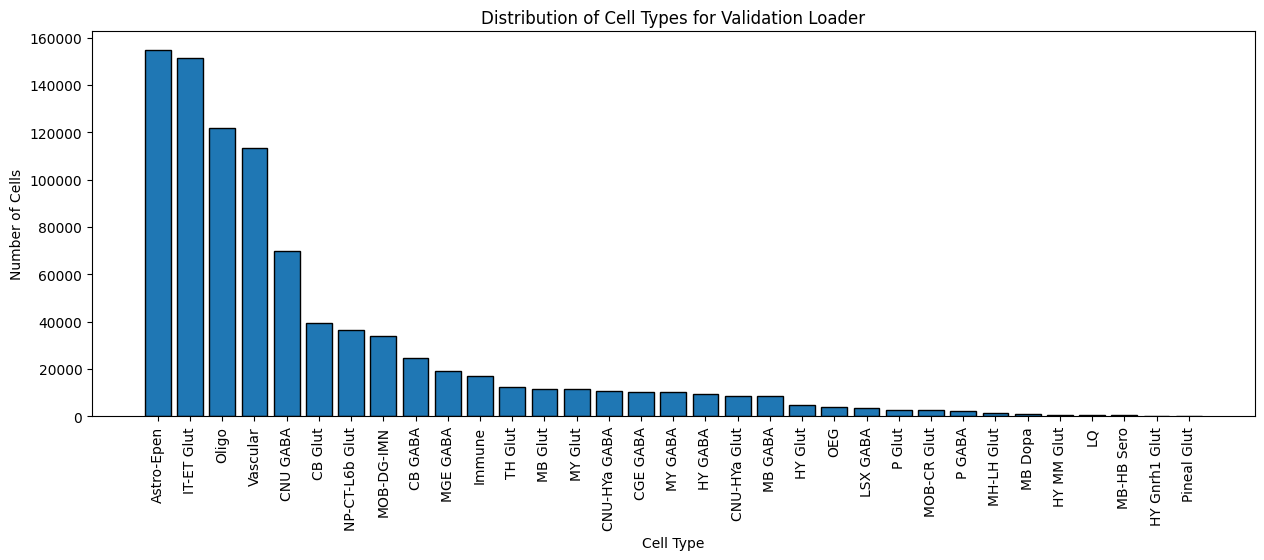

In [31]:
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np

def plot_histogram(loader, title, cell_num_path, cell_type_path):
    # Extracting number of cells in x
    num_cells = [data.x.size(0) for data in loader]

    # Plotting histogram for number of cells in x
    plt.figure(figsize=(10, 5))
    plt.hist(num_cells, bins=30, edgecolor='black')
    plt.title(f'Number of Cells in Images for {title}')
    plt.xlabel('Number of Cells')
    plt.ylabel('Number of Images')
    plt.yticks(np.arange(0, max(plt.yticks()[0]), 1)) # Set y-ticks to integer values
    plt.savefig(cell_num_path) # Save the plot
    plt.show()

    # Extracting cell types
    cell_types = [data.cell_type.tolist() for data in loader]
    flat_cell_types = [item for sublist in cell_types for item in sublist]

    # Get the encode_book from the first data object in the loader
    encode_book = next(iter(loader)).encode_book

    # Count the frequency of each cell type
    cell_type_counts = Counter(flat_cell_types)

    # Sort cell types by frequency
    sorted_cell_types = sorted(cell_type_counts.items(), key=lambda x: x[1], reverse=True)
    sorted_labels = [list(encode_book.keys())[cell_type[0]] for cell_type in sorted_cell_types] # Convert keys to list
    sorted_values = [cell_type[1] for cell_type in sorted_cell_types]

    # Plotting histogram for distribution of cell types
    plt.figure(figsize=(15, 5))
    plt.bar(range(len(sorted_values)), sorted_values, edgecolor='black')
    plt.title(f'Distribution of Cell Types for {title}')
    plt.xlabel('Cell Type')
    plt.ylabel('Number of Cells')
    plt.xticks(ticks=range(len(sorted_labels)), labels=sorted_labels, rotation=90)
    plt.savefig(cell_type_path) # Save the plot
    plt.show()

# Plot histograms for train_loader and val_loader
plot_histogram(train_loader, 'Train Loader', "./processed_data/plots/pre_trainloader_cell_num.jpg", "./processed_data/plots/pre_trainloader_cell_type.jpg")
plot_histogram(val_loader, 'Validation Loader', "./processed_data/plots/pre_valloader_cell_num.jpg", "./processed_data/plots/pre_valloader_cell_type.jpg")


In [7]:
import torch
torch.save(graph_list, './processed_data/img59_r30_n1_random_01.pt')

KeyboardInterrupt: 

In [7]:
'''
# Replace 'data_constracter.adata.obs' with your actual DataFrame variable.
class_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()
class_label_counts.columns = ["class_label", "count"]
class_label_counts = class_label_counts.sort_values(by="count", ascending=False)
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Set Seaborn style
sns.set_style("whitegrid")

plt.figure(figsize=(10, 6))  # Adjust the figure size as needed

# Plot the bars
plt.bar(class_label_counts["class_label"], class_label_counts["count"])

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Label Counts")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=90, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
'''

'\n# Replace \'data_constracter.adata.obs\' with your actual DataFrame variable.\nclass_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()\nclass_label_counts.columns = ["class_label", "count"]\nclass_label_counts = class_label_counts.sort_values(by="count", ascending=False)\nplt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n\n# Set Seaborn style\nsns.set_style("whitegrid")\n\nplt.figure(figsize=(10, 6))  # Adjust the figure size as needed\n\n# Plot the bars\nplt.bar(class_label_counts["class_label"], class_label_counts["count"])\n\n# Add labels and title\nplt.xlabel("Class Label")\nplt.ylabel("Count")\nplt.title("Class Label Counts")\n\n# Rotate x-axis labels for better readability (optional)\nplt.xticks(rotation=90, ha=\'right\')\n\n# Display the plot\nplt.tight_layout()\nplt.show()\n'

In [8]:
'''
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'data_constracter.adata.obs' is your DataFrame
class_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()
class_label_counts.columns = ["class_label", "count"]
class_label_counts = class_label_counts.sort_values(by="count", ascending=False)

# Set Seaborn style
sns.set_style("whitegrid")

# Create the bar plot using Seaborn with blue color
plt.figure(figsize=(10, 6))
sns.barplot(x="class_label", y="count", data=class_label_counts, color="blue")

# Add labels and title
plt.xlabel("Class Label")
plt.ylabel("Count")
plt.title("Class Label Counts")

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45, ha='right')

# Display the plot
plt.tight_layout()
plt.show()
'''

'\nimport pandas as pd\nimport matplotlib.pyplot as plt\nimport seaborn as sns\n\n# Assuming \'data_constracter.adata.obs\' is your DataFrame\nclass_label_counts = data_constracter.adata.obs["class_label"].value_counts().reset_index()\nclass_label_counts.columns = ["class_label", "count"]\nclass_label_counts = class_label_counts.sort_values(by="count", ascending=False)\n\n# Set Seaborn style\nsns.set_style("whitegrid")\n\n# Create the bar plot using Seaborn with blue color\nplt.figure(figsize=(10, 6))\nsns.barplot(x="class_label", y="count", data=class_label_counts, color="blue")\n\n# Add labels and title\nplt.xlabel("Class Label")\nplt.ylabel("Count")\nplt.title("Class Label Counts")\n\n# Rotate x-axis labels for better readability (optional)\nplt.xticks(rotation=45, ha=\'right\')\n\n# Display the plot\nplt.tight_layout()\nplt.show()\n'

In [ ]:
# Load the data list
graph_list = torch.load('./processed_data/img6.pt')

In [17]:
train_loader,val_loader = split_dataset(graph_list, batch_size=1,split_percent=(0.8, 0.2, 0),pre_train=True)

In [18]:
train_loader

Train size: 4
Validation size: 2


In [17]:
for x in train_loader:
    print(x)
    break

DataBatch(x=[51012, 550], edge_index=[2, 419170], edge_attr=[51012, 51012], cell_mask_index=[10202], cell_type=[51012], image=[1], num_nodes=51012, batch=[51012], ptr=[2])


In [19]:
# Assuming gene_expression is your target variable after masking
#variance_after_masking = torch.var(x.y.to_dense().float())
#print("Variance after masking:", variance_after_masking.item())

In [23]:
from torch import nn, optim, Tensor
import torch
from torch_geometric.nn import GCNConv,GATConv
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import r2_score
from torch.nn import LeakyReLU, Dropout
import time
from torch.utils.checkpoint import checkpoint


class GCN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GCN_1(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)

        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.act(self.conv1(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GCN_2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, hidden_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = checkpoint(self.conv2, x, edge_index)
        x = self.act(self.conv3(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x

class GNN(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GCNConv(in_channels, hidden_channels)
        self.conv2 = GCNConv(hidden_channels, hidden_channels)
        self.conv3 = GCNConv(hidden_channels, out_channels)
        self.conv4 = GCNConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, hidden_channels)
        self.conv3 = GATConv(hidden_channels, out_channels)
        self.conv4 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.dropout(self.act(self.conv2(x, edge_index)))
        x = self.dropout(self.act(self.conv3(x, edge_index)))
        x = self.act(self.conv4(x, edge_index))  # Typically, dropout is not applied to the final layer.
        return x
    
class GAT_2(nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout_rate=0.5):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels)
        self.conv2 = GATConv(hidden_channels, out_channels)
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()
        

    def forward(self, x: Tensor, edge_index: Tensor) -> Tensor:
        x = self.dropout(self.act(self.conv1(x, edge_index)))
        x = self.act(self.conv2( x, edge_index)) # Using checkpointing on the final layer
        return x
    
class GAT_4(nn.Module):
    def __init__(self, in_channels, hidden_channels_1,hidden_channels_2, out_channels, dropout_rate=0.2):
        super().__init__()
        self.conv1 = GATConv(in_channels, hidden_channels_1)
        self.conv2 = GATConv(hidden_channels_1, hidden_channels_2)
        self.conv3 = GATConv(hidden_channels_2, hidden_channels_1)
        self.conv4 = GATConv(hidden_channels_1, out_channels)

        
        self.dropout = Dropout(dropout_rate)
        self.act = nn.LeakyReLU()
        
    
    def forward(self, x, edge_index):
        x = self.act(self.conv1(x, edge_index))
        x = self.dropout(x)
        x = self.act(self.conv2(x, edge_index))
        x = self.act(self.conv3(x, edge_index))
        x = self.conv4(x, edge_index)
        return x


In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')  #"cpu"
device

device(type='cpu')

In [25]:
# Pretraining
# Define the device
device =  torch.device('cuda' if torch.cuda.is_available() else 'cpu') #"cpu"

# Create the model
model = GAT_4(550, 256,33, 550).to(device) # in_channels is set to 100 as an example. Please replace it with your actual feature size.

# Define loss function and optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = StepLR(optimizer, step_size=80, gamma=0.1) # learning rate scheduler

num_epochs = 150
patience = 8

train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, num_epochs= num_epochs, patience = patience, optimizer= optimizer,weight_loss = True ,model_path = './models/img6_random_01_GAT4.pt')

Epoch 1/150, train loss: 0.0020, train r2: -0.3558, train mse: 1.0403,  val loss: 0.0013, val r2: -0.2840, val mse: 1.0312, Time: 162.6087s
Epoch 2/150, train loss: 0.0018, train r2: -0.3217, train mse: 0.9940,  val loss: 0.0011, val r2: -0.2963, val mse: 0.9597, Time: 215.1677s
Epoch 3/150, train loss: 0.0016, train r2: -0.3219, train mse: 0.9303,  val loss: 0.0010, val r2: -0.2633, val mse: 0.8981, Time: 224.6461s


KeyboardInterrupt: 

In [ ]:
from sklearn.model_selection import KFold

# Split the dataset into k folds
k_folds = 10
loaders = split_dataset(dataset, k_folds=k_folds, batch_size=1) # Assuming dataset is your data

# Store the results for each fold
results = []

# Iterate through each fold
for fold, (train_loader, val_loader) in enumerate(loaders):
    print(f"Training Fold {fold + 1}/{k_folds}")

    # Create a new model for each fold
    model = GAT_2(550, 550, 550).to(device)

    # Define loss function and optimizer
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Train and validate the model for this fold
    train(model=model, train_loader=train_loader, val_loader=val_loader, criterion=criterion, num_epochs=num_epochs, patience=patience, optimizer=optimizer)

    # Optionally, you can store the results for this fold
    results.append((train_loss, val_loss)) # You'll need to modify the train function to return these values

# Optionally, you can aggregate the results across all folds
# For example, you could compute the mean validation loss across all folds
mean_val_loss = sum(val_loss for _, val_loss in results) / k_folds
print(f"Mean Validation Loss: {mean_val_loss:.4f}")


In [48]:
#Load model

# Loading the Model
# Define the device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Recreate the model structure (it should match the saved model)
model = GCN_1(550, 550, 550).to(device)

# Load the saved model weights
model_path = './models/model.pt'
model.load_state_dict(torch.load(model_path))
model.eval() # Set the model in evaluation mode

# Downstream Tasks
# For example, let's predict on a test set

# Loading test data
# Replace this line with the appropriate code to load your test data
test_loader

# Evaluating the model on the test set

with torch.no_grad():
    for data in test_loader:

        target = data.y.float().to_dense()

        outputs = model(data.x.float().to(device), data.edge_index.long().to(device))
        loss = criterion(outputs[data.mask],target.to(device))
        
        print(loss)






tensor(1.0352, device='cuda:0')
tensor(0.9649, device='cuda:0')


In [25]:
from tqdm.auto import tqdm
def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_test_loss = 0
    test_targets_list = []
    test_outputs_list = []
    test_celltypes_list = []

    for data in tqdm(test_loader):
        with torch.no_grad():

            outputs = model(data.x.float().to(device), data.edge_index.to(device).long())
            loss = criterion(outputs[data.mask], data.y.float())
        total_test_loss += loss.item() * data.num_graphs
        test_celltypes_list.append(data.cell_type_masked)
        test_targets_list.append(expression_masked.float())
        test_outputs_list.append(outputs[data.mask])

    # Measure and print test loss and R2
    test_loss = total_test_loss / len(test_loader.dataset)
    test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(),
                       torch.cat(test_outputs_list).cpu().detach().numpy())
    print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")
        # Return test loss and r2 for further use
    return test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list

In [26]:

def test(model, test_loader, criterion, device):
    model.to(device)
    model.eval()
    
    total_test_loss = 0
    test_targets_list = []
    test_outputs_list = []
    test_celltypes_list = []

    for data in tqdm(test_loader):
        with torch.no_grad():
            
            outputs = model(data.x.float().to(device), data.edge_index.to(device).long())
            loss = criterion(outputs[data.mask], data.y.to_dense().to(device))
        total_test_loss += loss.item() * data.num_graphs
        test_celltypes_list.append(data.cell_type_masked)
        test_targets_list.append(data.y.to_dense().float())
        test_outputs_list.append(outputs[data.mask])

    # Measure and print test loss and R2
    test_loss = total_test_loss / len(test_loader.dataset)
    test_r2 = r2_score(torch.cat(test_targets_list).cpu().detach().numpy(),
                       torch.cat(test_outputs_list).cpu().detach().numpy())
    print(f"Test loss: {test_loss:.4f}, test r2: {test_r2:.4f}")
        # Return test loss and r2 for further use
    return test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list

In [27]:
test_loss, test_r2,test_targets_list,test_outputs_list,test_celltypes_list = test(model, test_loader, criterion, device)

  0%|          | 0/1 [00:00<?, ?it/s]

Test loss: 0.3829, test r2: 0.1627


In [28]:
len(test_celltypes_list)

1

In [83]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

# usage
model = GCN_2(550, 550, 550)  # Replace with your actual model
print(f'The model has {count_parameters(model):,} parameters')


The model has 909,150 parameters


In [31]:
import itertools
# Flatten the nested list into a single-dimensional list
flattened_list = list(itertools.chain.from_iterable(test_celltypes_list))
flattened_list = list(itertools.chain.from_iterable(flattened_list))

In [29]:
len(test_targets_list)

1

In [86]:
len(torch.cat(test_targets_list).cpu().detach().numpy())

11720

In [87]:
len(torch.cat(test_targets_list).cpu().detach().numpy())

11720

In [88]:
print(len(flattened_list))
print(len(r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')))

11720
11720


In [89]:
flattened_list[0:5]

[2, 19, 19, 2, 0]

In [90]:
data_constracter.adata.var_names[0:5]

Index(['Prkcq', 'Col5a1', 'Grik3', 'Igfbp2', 'Osr1'], dtype='object')

In [91]:
print(len(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy())))
np.transpose(torch.cat(test_targets_list).cpu().detach().numpy())

550


array([[0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [4.6709228, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.0698248, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [92]:
print(len(torch.cat(test_targets_list).cpu().detach().numpy()))
torch.cat(test_targets_list).cpu().detach().numpy()

11720


array([[0.       , 4.6709228, 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 1.0698248, ..., 0.       , 0.       ,
        0.       ],
       ...,
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ],
       [0.       , 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ]], dtype=float32)

In [32]:
import pandas as pd

preds_test_per_cell = pd.DataFrame({'celltype': flattened_list, 'r2_score': r2_score(np.transpose(torch.cat(test_targets_list).cpu().detach().numpy()), np.transpose(torch.cat(test_outputs_list).cpu().detach().numpy()), multioutput='raw_values')})

preds_test_per_gene = pd.DataFrame({'gene': data_constracter.adata.var_names, 'r2_score': r2_score(torch.cat(test_targets_list).cpu().detach().numpy(), torch.cat(test_outputs_list).cpu().detach().numpy(), multioutput='raw_values')})



In [33]:
preds_test_per_cell[0:5]

,celltype,r2_score
0,0,0.725736
1,32,0.429747
2,0,0.499048
3,11,0.669672
4,0,0.508246


In [34]:
preds_test_per_gene[0:5]

,gene,r2_score
0,Prkcq,0.099756
1,Col5a1,0.232568
2,Grik3,0.289075
3,Igfbp2,0.508025
4,Osr1,0.248125


In [108]:
# huge class inbalance problem, need to handel -> add weight?
# add pooling

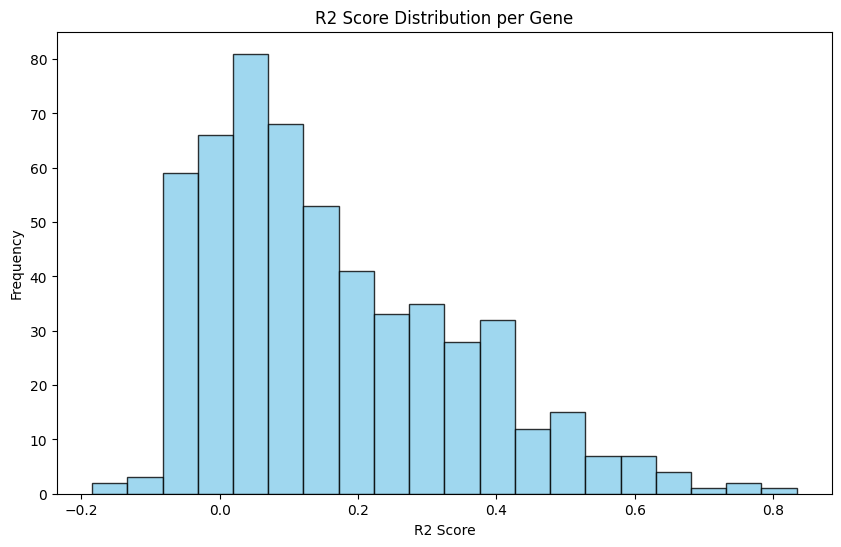

        gene  r2_score
214  Slc17a7  0.833875
234     Aqp1  0.752764
181    Clic6  0.736130
31      Gfap  0.699421
328       Kl  0.670935
..       ...       ...
386   Pou4f1 -0.095043
213  Mab21l2 -0.112723
200   Slc6a5 -0.122838
129    Hoxb5 -0.143137
410     Lhx8 -0.184446

[550 rows x 2 columns]


In [35]:
import matplotlib.pyplot as plt

# Plotting the histogram
plt.figure(figsize=(10,6))
plt.hist(preds_test_per_gene['r2_score'], bins=20, alpha=0.8, color='skyblue', edgecolor='black')
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.ylabel('Frequency')
plt.show()

# Sorting by r2_score
preds_test_per_gene = preds_test_per_gene.sort_values(by='r2_score', ascending=False)

# Display the sorted DataFrame
print(preds_test_per_gene)


,gene,r2_score
214,Slc17a7,0.833875
234,Aqp1,0.752764
181,Clic6,0.736130
31,Gfap,0.699421
328,Kl,0.670935
...,...,...
386,Pou4f1,-0.095043
213,Mab21l2,-0.112723
200,Slc6a5,-0.122838
129,Hoxb5,-0.143137


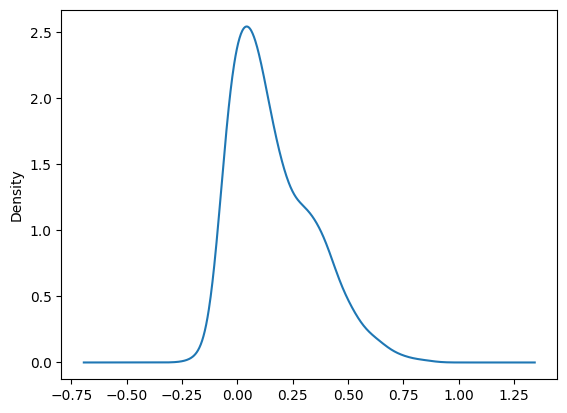

In [36]:
preds_test_per_gene

# plot r2 score distribution per gene, histogram
# density plot
preds_test_per_gene.r2_score.plot.kde()
#preds_test_per_gene.r2_score.plot.hist(bins=20, alpha=0.8)

# plot r2 score distribution per celltype, histogram
#preds_test_per_cell.r2_score.plot.hist(bins=10, alpha=0.8)

# sort by r2 score
preds_test_per_gene.sort_values(by='r2_score', ascending=False, inplace=True)
preds_test_per_gene

In [39]:
preds_test_per_gene

,gene,r2_score
214,Slc17a7,0.833875
234,Aqp1,0.752764
181,Clic6,0.736130
31,Gfap,0.699421
328,Kl,0.670935
...,...,...
386,Pou4f1,-0.095043
213,Mab21l2,-0.112723
200,Slc6a5,-0.122838
129,Hoxb5,-0.143137


In [111]:
preds_test_per_cell

,celltype,r2_score
0,2,0.337519
1,19,0.429346
2,19,0.314214
3,2,0.395540
4,0,0.489159
...,...,...
11715,16,0.373429
11716,2,0.397199
11717,16,0.461380
11718,23,0.267912


In [42]:
filtered_rows = preds_test_per_gene[preds_test_per_gene['gene'].str.contains('Blank')]
filtered_rows

,gene,r2_score
532,Blank-10,0.165592
524,Blank-42,0.065440
530,Blank-8,0.037748
528,Blank-50,0.036417
541,Blank-32,0.033135
548,Blank-23,0.004863
509,Blank-6,0.003013
521,Blank-39,-0.000325
500,Blank-36,-0.002621
531,Blank-9,-0.003341


In [100]:
import torch

# Replace 'model.pt' with the actual file path of your model
model_path = "./models/model_fillomgGAT2.pt"

# Define your model architecture (make sure it matches the architecture used to save the model)
# Example: If you have a class named 'MyModel', you would need to create an instance of it first.
# model = MyModel()

# Load the model from the file
state_dict = torch.load(model_path)

# Load the state dictionary into the model
model.load_state_dict(state_dict)

# If you saved the model on a GPU and want to use it on the CPU, use the following line:
# state_dict = torch.load(model_path, map_location=torch.device('cpu'))
# model.load_state_dict(state_dict)

# Put the model in evaluation mode if it contains dropout, batch norm, etc.
model.eval()

FileNotFoundError: [Errno 2] No such file or directory: './models/model_fillomgGAT2.pt'

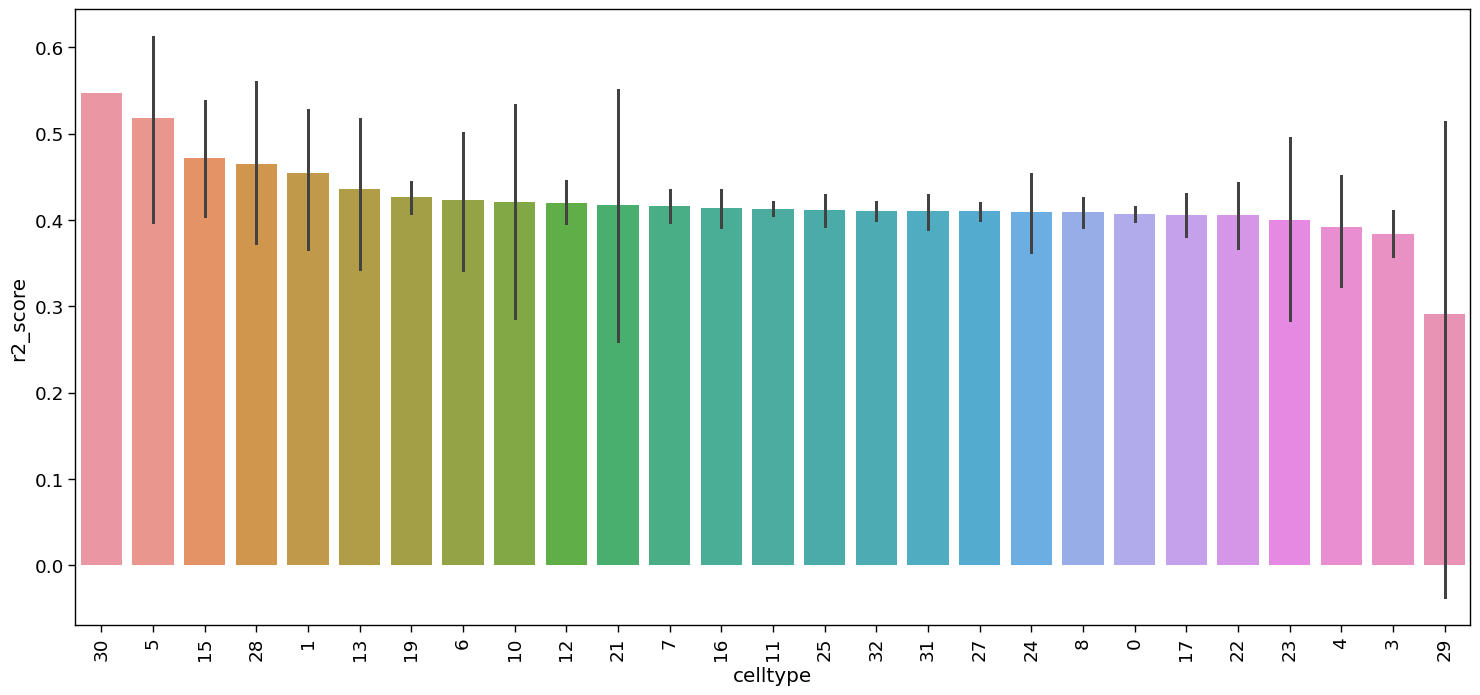

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

# set style
sns.set_palette("colorblind")
sns.set_context("paper", font_scale=1.5)

# make plot larger
plt.figure(figsize=(18,8))

# rotate x-axis labels
plt.xticks(rotation=90)

# create plot of mean R2 score per celltype
# order bars by mean R2 score

# add avlue counts from adata.obs.class_label.value_counts()
ax = sns.barplot(x="celltype", y="r2_score", data=preds_test_per_cell, order=preds_test_per_cell.groupby('celltype').mean().sort_values(by='r2_score', ascending=False).index)

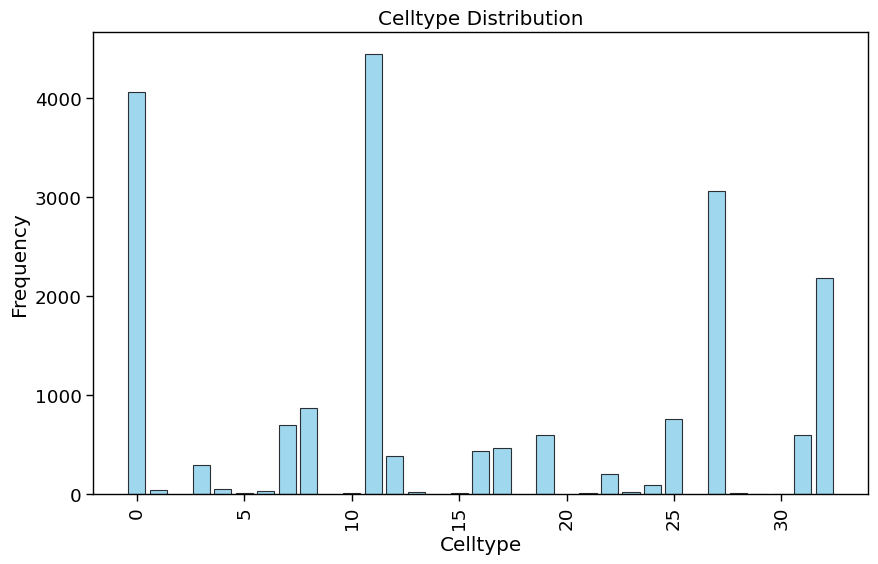

In [44]:
import pandas as pd
import matplotlib.pyplot as plt

# Get the frequency of each celltype
celltype_counts = preds_test_per_cell['celltype'].value_counts().sort_values(ascending=False)

plt.figure(figsize=(10,6))
plt.bar(celltype_counts.index, celltype_counts.values, alpha=0.8, color='skyblue', edgecolor='black')
plt.xticks(rotation='vertical')
plt.xticks(rotation=90)
plt.title('Celltype Distribution')
plt.xlabel('Celltype')
plt.ylabel('Frequency')
plt.show()


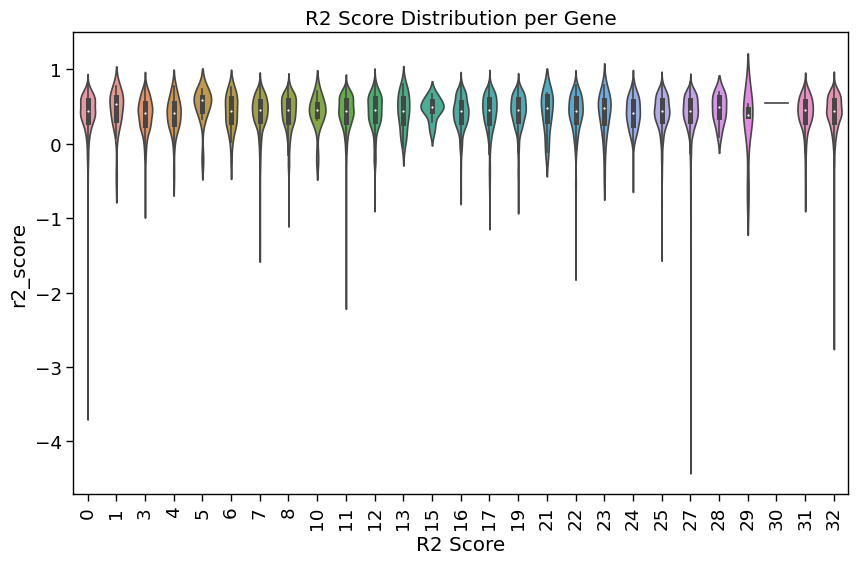

In [45]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
sns.violinplot(x="celltype", y="r2_score", data=preds_test_per_cell)
# rotate x-axis labels
plt.xticks(rotation=90)
plt.title('R2 Score Distribution per Gene')
plt.xlabel('R2 Score')
plt.show()


In [66]:
file_path = "./data/subset_6img_atlas_brain.h5ad"
root_path = "./data"
dataset = InMemoryGraphDataset(root= root_path,
                               data_names = "data_test",
                               file_path=file_path, image_col="section", label_col="class_label", include_label=False, radius=20,node_level = 1, batch_size=1)



Processing...


AttributeError: 'InMemoryGraphDataset' object has no attribute 'data_loader'

In [ ]:
# Load your dataset
import torch
data = torch.load('./data/data_test.pt')